# 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# CLT : 중심극한정리
모집단의 확률분포와 상관없이 랜덤샘플의 평균을 표준화 하면 샘플이 충분히 많을 때 표준정규분포에 근사한다. \
이것을 아래의 문제를 통해 확인해보자

## [CLT : 문제 1]
확률변수 $X, Y, Z$가 각각 다음의 확률분포를 따른다고 하자 \
$X \sim Uniform(-4,2)$ \
$Y \sim Gamma(3,6)$ \
$Z \sim Beta(4,2)$

<br/>

$D \sim X + Y + Z$에 대하여 $\bar{D} =  \frac{1}{N} \sum_{i=1}^N D_i$라 할때 \
$\frac{\sqrt{N}(\bar{D}-E[D])}{std(D)} \sim Nomal(0,1)$인지 시각화하여 확인해보자

<br/>

아래의 코드에서 $N = 10$, $n = 150$으로 평균과 표준편차의 추정량은 다음과 같이 구하자 \
$E[D] = \frac{1}{n} \sum_{i=1}^n \bar{D_i}$ \
$\frac{1}{\sqrt{N}}std(D) = std(\bar{D}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (\bar{D_i} - E[D]})^2$


In [2]:
class CLT:
    def __init__(self, N=10):
        self.N = N

    def data_samppling(self, size):
        X = np.random.uniform(-4, 2, (self.N, size))
        Y = np.random.gamma(3, 6, (self.N, size))
        Z = np.random.beta(4, 2, (self.N, size))
        data = (X + Y + Z).mean(axis=0)
        self.nomal_data = (data - data.mean()) / (data.std())

    def show(self, sample_szie=150):
        def init():
            self.data_samppling(sample_szie)

        def update(sample_size):
            ax.clear()
            ax.set_xlim(-5, 5)
            ax.set_ylim(0, 0.8)
            ax.set_title(f"sample_size : {sample_size}")
            x = np.arange(-5, 5, 0.01)
            ax.plot(x, stats.norm.pdf(x, loc=0, scale=1), alpha=0.5)
            pd.Series(self.nomal_data[:sample_size]).plot(kind="density", alpha=0.5, ax=ax)
            ax.legend(["NomalDistribution", "SampleData"])

        fig, ax = plt.subplots()
        ani = FuncAnimation(fig, update, frames=range(2, sample_szie + 1), init_func=init)
        plt.close()
        return HTML(ani.to_html5_video())

In [3]:
A = CLT()
A.show()

# MLE : 최대가능도추정량
최대가능도 추정량의 정규근사 성질과 불변성에 대하여 아래의 문제를 통해 알아보자!

## [MLE : 문제 1]
$i = 1, 2, ... , N$에 대하여 $X_i \sim f(x|\theta)$일때 $N$이 충분히 크면 $\theta$의 MLE $\hat{\theta}$에 대하여 다음이 성립한다. \
$(\theta - \hat{\theta}) \sim Nomal(0,\frac{1}{nI(\theta)})$ where $I({\theta})$ : 피셔정보수 \
pdf : $f(x|\theta) = \theta e^{-\theta x}, x>0$일때 \
cdf의 역함수를 구하여 데이터를 샘플링하고 샘플링 한 데이터에 대하여 \
최대가능도 추정량의 정규근사를 이용해 $\theta$의 95% 신뢰구간을 N이 2 ~ 10000의 변화에 대하여 시각화 해보자
- 아래의 문제에서는 $\theta = 2$인 경우이다

In [4]:
class MLE:
    def __init__(self, theta, N=10000):
        self.theta = theta
        self.N = N

        self.init_f(theta)
        self.X = np.apply_along_axis(self.inverse_cdf, 0, np.random.uniform(size=N))
        self.norm_dist = stats.norm(0, 1)

    def init_f(self, theta):
        def pdf(x, theta=theta):
            return theta * np.exp(-theta * x)

        def inverse_cdf(t, theta=theta):
            return -np.log(1 - t) / theta

        def mle(X):
            return 1 / X.mean()

        self.pdf = pdf
        self.inverse_cdf = inverse_cdf
        self.compute_mle = mle

    def compute_n_fisher(self, X):
        self.mle = self.compute_mle(X)
        self.n_fisher = len(X) * X.mean() ** 2

    def confidence_interval(self, a=0.95):
        a = (1 - a) / 2
        lower = self.mle + self.norm_dist.ppf(a) / self.n_fisher**0.5
        upper = self.mle + self.norm_dist.ppf(1 - a) / self.n_fisher**0.5
        return lower, upper

    def make_result(self):
        L, U = [], []
        for idx in range(2, len(self.X)):
            X = self.X[:idx]
            self.compute_n_fisher(X)
            l, u = self.confidence_interval()
            L.append(l)
            U.append(u)
        pd.DataFrame({"Lower Bound": L, "Upper Bound": U}).plot()
        plt.axhline(self.theta, 0, 1, color="red", linestyle="-", linewidth=2)
        plt.ylim(self.theta - 1, self.theta + 1)

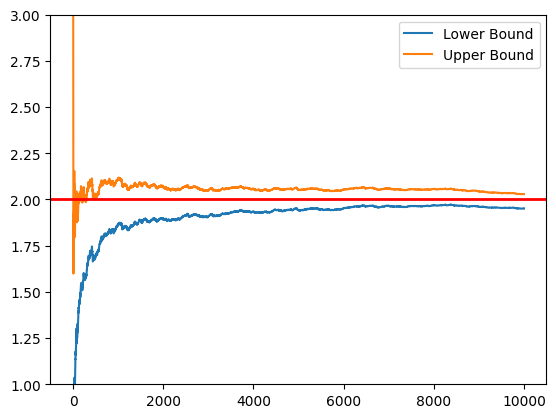

In [5]:
B = MLE(2)
B.make_result()

## [MLE : 문제 2]
위의 문제에서 pdf가 다음과 같이 바뀌어서 pdf : $f(x|\theta) = \sqrt{\theta} e^{-\sqrt{\theta} x}, x>0$일때 \
최대가능도 추정량의 **불변성**과 정규근사를 이용해 $\theta$의 95% 신뢰구간을 N이 2 ~ 10000의 변화에 대하여 시각화 해보자\
이번에는 $nI(\theta) = - n E[{\partial^2\over\partial \theta^2} \ln f(x|\theta)] \approx - \sum_{i=1}^n {\partial^2\over\partial \theta^2} \ln f(x|\theta = \hat{\theta})$로 구해보자
- 아래의 문제에서는 $\theta = 3$인 경우이다

In [6]:
class MLE2(MLE):
    def __init__(self, theta, N=10000):
        super().__init__(theta, N)

    def init_f(self, theta):
        def pdf(x, theta=theta):
            return (theta**0.5) * np.exp(-(theta**0.5) * x)

        def inverse_cdf(t, theta=theta):
            return -np.log(1 - t) / (theta**0.5)

        def mle(X):
            return 1 / X.mean() ** 2

        self.pdf = pdf
        self.inverse_cdf = inverse_cdf
        self.compute_mle = mle

    def compute_n_fisher(self, X, h=1e-6):
        self.mle = self.compute_mle(X)
        r = np.log(self.pdf(X, self.mle + h))
        m = np.log(self.pdf(X, self.mle))
        l = np.log(self.pdf(X, self.mle - h))
        self.n_fisher = -((r - 2 * m + l) / h**2).sum()

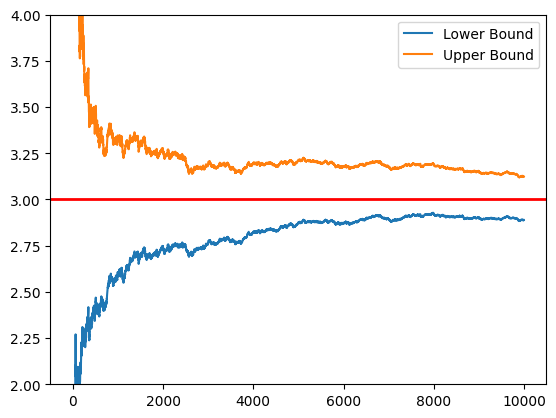

In [7]:
C = MLE2(3)
C.make_result()

# Version
- Python==3.8.18
- numpy==1.24.3
- matplotlib==3.6.2
- IPython==8.12.0
- scipy==1.7.3
- pandas==1.4.4